In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv1D
#from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving testbiglist.json to testbiglist.json
Saving trainbiglist.json to trainbiglist.json


In [ ]:
indices = np.where(arr2d!=0.5)
indexx,indexy = indices[1],indices[0]

#print(indices)

#print(indexx)
#print(indexy)

arr2d[arr2d==0.5] = 0

In [ ]:
def load_json(input_file):
    with open(input_file) as f:
    
        reading = json.load(f)
    return reading

train_list = np.array(load_json("trainbiglist.json"))
test_list = np.array(load_json("testbiglist.json"))

train_X = np.expand_dims(train_list,axis=-1)
test_X = np.expand_dims(test_list,axis=-1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
print(train_X.shape)
print(test_X.shape)

(64, 150, 150, 1)
(8, 150, 150, 1)


In [ ]:
#build the encoder
inputs = Input((150,150,1))
x = inputs

x = Conv2D(32, (3,3), strides=1, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=-1)(x)

x = Conv2D(16, (3,3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=-1)(x)

x = Conv2D(32, (3,3), strides=1, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=-1)(x)

volumeSize = K.int_shape(x)
x = Flatten()(x)
latent = Dense(1800)(x)
encoder = Model(inputs, latent, name="encoder")

print(encoder.summary())

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 150, 150, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 16)        4624      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 75, 75, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 16)        64  

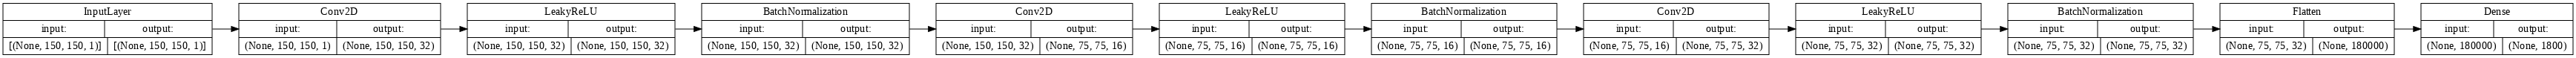

In [ ]:
plot_model(
    encoder,
    to_file="encoder.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir="LR",
    expand_nested=True,
    dpi=72,
)

In [ ]:
#build the decoder
latentInputs = Input(shape=(1800,))
x = Dense(np.prod(volumeSize[1:]))(latentInputs)
x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

x = Conv2DTranspose(32, (3, 3), strides=1, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=-1)(x)

x = Conv2DTranspose(16, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=-1)(x)

x = Conv2DTranspose(32, (3, 3), strides=1, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=-1)(x)

x = Conv2DTranspose(1, (3, 3), padding="same")(x)
outputs = Activation("sigmoid")(x)

decoder = Model(latentInputs, outputs, name="decoder")
print(decoder.summary())

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1800)]            0         
_________________________________________________________________
dense_2 (Dense)              (None, 180000)            324180000 
_________________________________________________________________
reshape_1 (Reshape)          (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 75, 75, 32)        9248      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 75, 75, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 150, 150, 16)      4624

In [ ]:
#build the autoencoder
autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")
print(autoencoder.summary())

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
encoder (Functional)         (None, 1800)              324011704 
_________________________________________________________________
decoder (Functional)         (None, 150, 150, 1)       324199121 
Total params: 648,210,825
Trainable params: 648,210,505
Non-trainable params: 320
_________________________________________________________________
None


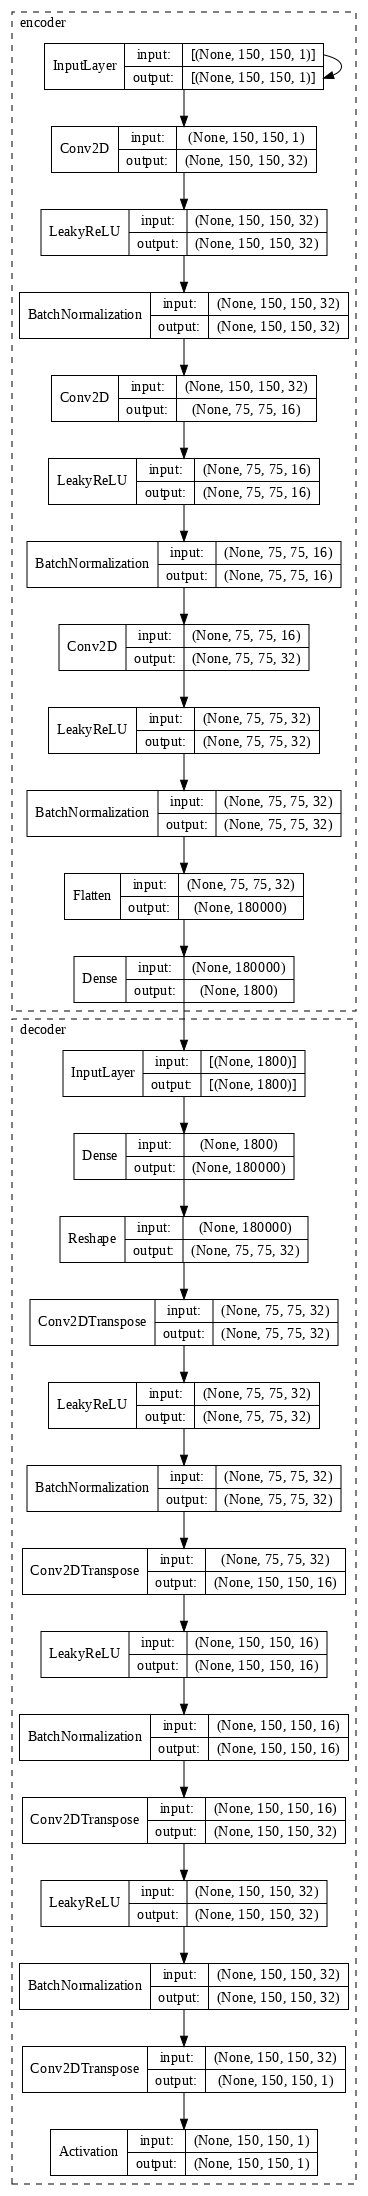

In [ ]:
plot_model(
    autoencoder,
    to_file="encoder.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir="LR",
    expand_nested=True,
    dpi=72,
)

In [ ]:
autoencoder.compile(optimizer=Adam(lr=1e-3), loss="mean_squared_error")

In [ ]:
#train the model
history = autoencoder.fit(
	train_X, train_X,
	validation_data=(test_X, test_X),
	epochs=100)

Epoch 1/100
2/2 [==============================] - 24s 10s/step - loss: 0.2842 - val_loss: 0.2277
Epoch 2/100
2/2 [==============================] - 18s 10s/step - loss: 0.2498 - val_loss: 0.2253
Epoch 3/100
2/2 [==============================] - 23s 13s/step - loss: 0.2154 - val_loss: 0.2188
Epoch 4/100
2/2 [==============================] - 19s 9s/step - loss: 0.2035 - val_loss: 0.2134
Epoch 5/100
2/2 [==============================] - 18s 9s/step - loss: 0.1947 - val_loss: 0.2084
Epoch 6/100
2/2 [==============================] - 19s 10s/step - loss: 0.1850 - val_loss: 0.2043
Epoch 7/100
2/2 [==============================] - 18s 9s/step - loss: 0.1748 - val_loss: 0.1987
Epoch 8/100
2/2 [==============================] - 18s 10s/step - loss: 0.1635 - val_loss: 0.1900
Epoch 9/100
2/2 [==============================] - 18s 9s/step - loss: 0.1521 - val_loss: 0.1821
Epoch 10/100
2/2 [==============================] - 18s 10s/step - loss: 0.1367 - val_loss: 0.1793
Epoch 11/100
2/2 [=====

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
#train_acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']
xc=range(100)

In [ ]:
#plot the loss
plt.figure(1, figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'])
plt.style.use(['classic'])

In [ ]:
#plot the accuracy
plt.figure(2, figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc=3)
plt.style.use(['classic'])

In [ ]:
autoencoder.save('unsup_autoencoder.h5')

In [ ]:
def draw_grid(out):
  res=out.shape
  plt.imshow(out, cmap = "PiYG_r")
  plt.clim(0.0, 1.0)
  plt.gca().set_xticks(np.arange(-.5, res[1], 2), minor = True)
  plt.gca().set_yticks(np.arange(-.5, res[0], 2), minor = True)
  plt.grid(True, which="minor", color="w", linewidth = .6, alpha = 0.5)
  plt.colorbar()
  plt.show()

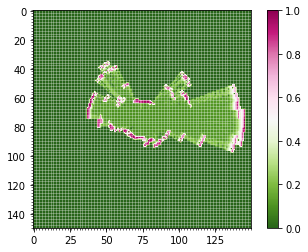

In [ ]:
out = train_list[10]
draw_grid(out)

In [ ]:
print(out.shape)
testX=np.expand_dims(out,axis=-1)
print(testX.shape)
testtX = np.reshape(testX, (1,150,150,1))
print(testtX.shape)

(150, 150)
(150, 150, 1)
(1, 150, 150, 1)


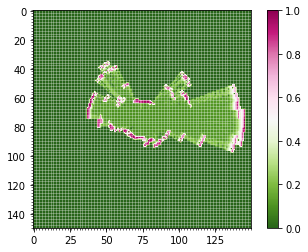

In [ ]:
checki = np.reshape(testtX, (150,150))
draw_grid(checki)

In [ ]:
decoded = autoencoder.predict(testtX)

In [ ]:
print(decoded.shape)

(1, 150, 150, 1)


In [ ]:
output = np.reshape(decoded, (150,150))

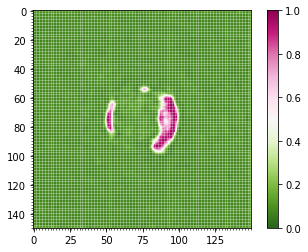

In [ ]:
draw_grid(output)